# EDA深堀り (2025-11-14)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import check_df

## データ読み込み

In [2]:
# データ読み込み
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

train.shape, test.shape

((517754, 14), (172585, 13))

## 基本情報の確認

In [3]:
train.head(3)

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30


In [4]:
test.head(3)

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1


In [5]:
check_df(train)

,Column,dtypes,NaN Count,Nunique,Unique Values
0,id,int64,0,517754,> 10 unique values
1,road_type,object,0,3,"[urban, rural, highway]"
2,num_lanes,int64,0,4,"[2, 4, 1, 3]"
3,curvature,float64,0,261,> 10 unique values
4,speed_limit,int64,0,5,"[35, 70, 60, 45, 25]"
5,lighting,object,0,3,"[daylight, dim, night]"
6,weather,object,0,3,"[rainy, clear, foggy]"
7,road_signs_present,bool,0,2,"[False, True]"
8,public_road,bool,0,2,"[True, False]"
9,time_of_day,object,0,3,"[afternoon, evening, morning]"


In [6]:
check_df(test)

,Column,dtypes,NaN Count,Nunique,Unique Values
0,id,int64,0,172585,> 10 unique values
1,road_type,object,0,3,"[highway, urban, rural]"
2,num_lanes,int64,0,4,"[2, 3, 4, 1]"
3,curvature,float64,0,195,> 10 unique values
4,speed_limit,int64,0,5,"[45, 35, 25, 70, 60]"
5,lighting,object,0,3,"[night, dim, daylight]"
6,weather,object,0,3,"[clear, foggy, rainy]"
7,road_signs_present,bool,0,2,"[True, False]"
8,public_road,bool,0,2,"[True, False]"
9,time_of_day,object,0,3,"[afternoon, evening, morning]"


## 数値型とカテゴリカル型の確認

In [7]:
# 数値型変数を抽出
num_features = train.select_dtypes(include=[np.number]).columns.tolist()
num_features.remove("id")
num_features.remove("accident_risk")
num_features

['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']

In [8]:
# カテゴリカル変数を抽出
cat_features = train.select_dtypes(include=["object", "bool"]).columns.tolist()
cat_features

['road_type',
 'lighting',
 'weather',
 'road_signs_present',
 'public_road',
 'time_of_day',
 'holiday',
 'school_season']

## 目的変数の分布

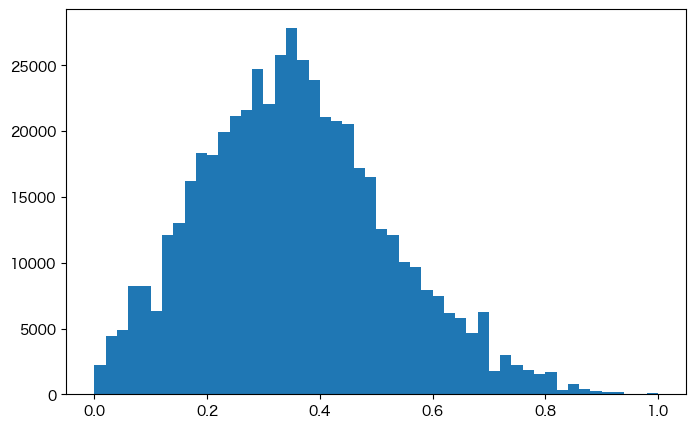

In [9]:
target_col = "accident_risk"

plt.figure(figsize=(8, 5))
plt.hist(train[target_col], bins=50)
plt.show()

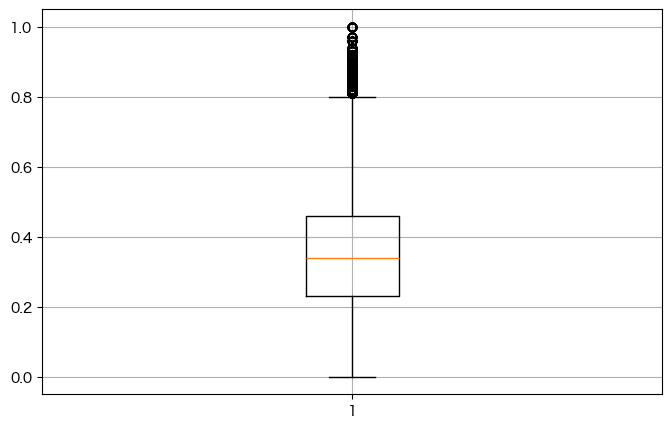

In [10]:
plt.figure(figsize=(8, 5))
plt.boxplot(train[target_col])
plt.grid()
plt.show()

In [27]:
# 正規分布度（PPCC）算出する関数
from scipy import stats

def normality_score_ppcc(x):
    x = np.asarray(x, float)
    x = x[~np.isnan(x)]
    # probplot の戻り値: (osm, osr), (slope, intercept, r)
    _, (slope, intercept, r) = stats.probplot(x, dist='norm')
    return float(r**2)  # 0〜1で、大きいほど正規っぽい

# コール部分
score = normality_score_ppcc(train[target_col])
print("PPCC:", score)
score = normality_score_ppcc(np.log1p(train[target_col]))
print("PPCC (LOG):", score)

PPCC: 0.9886057462499201
PPCC (LOG): 0.9966505019592758


対数変換後の分布

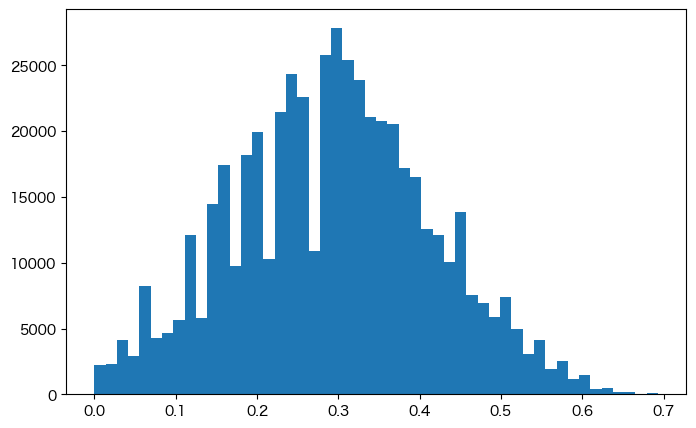

In [12]:
plt.figure(figsize=(8, 5))
plt.hist(np.log1p(train[target_col]), bins=50)
plt.show()

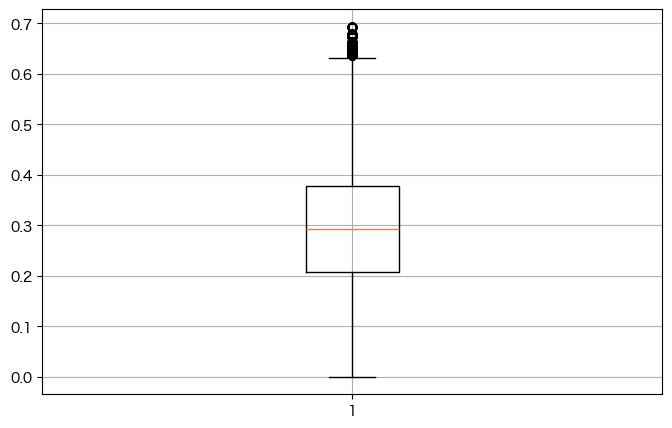

In [13]:
plt.figure(figsize=(8, 5))
plt.boxplot(np.log1p(train[target_col]))
plt.grid()
plt.show()

In [14]:
score = normality_score_ppcc(train[target_col])
print("PPCC:", score)

PPCC: 0.9886057462499201


## 数値型変数と目的変数の関係

相関係数

In [15]:
correlation_with_target = (
    train[num_features + [target_col]]
    .corr()[target_col]
    .drop(target_col)
    .sort_values(ascending=False)
)

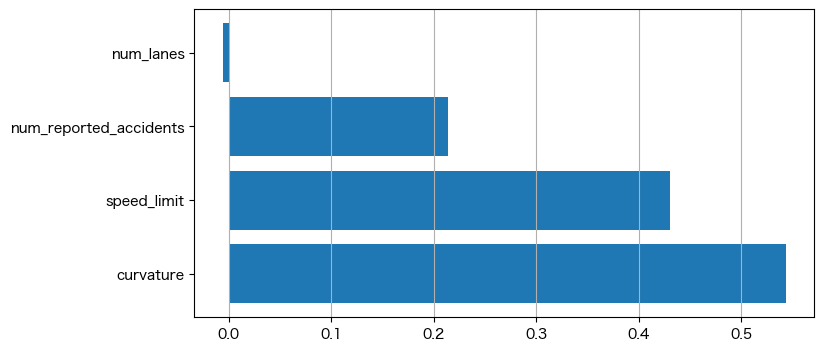

In [16]:
plt.figure(figsize=(8, 4))
plt.barh(range(len(correlation_with_target)), correlation_with_target.values)
plt.yticks(range(len(correlation_with_target)), correlation_with_target.index)
plt.grid(axis="x")
plt.show()

curvature

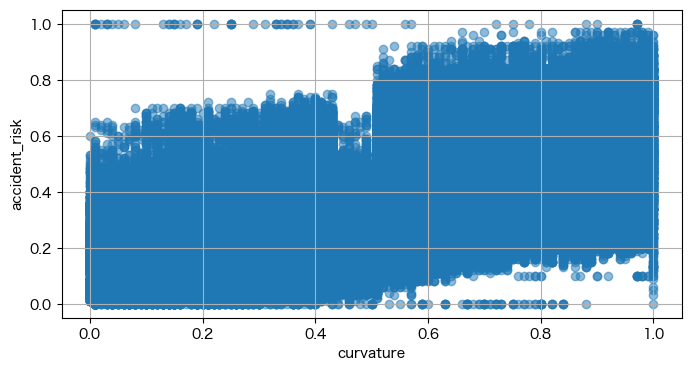

In [17]:
plt.figure(figsize=(8, 4))
plt.scatter(train["curvature"], train[target_col], alpha=0.5)
plt.xlabel("curvature")
plt.ylabel(target_col)
plt.grid()
plt.show()

speed_limit

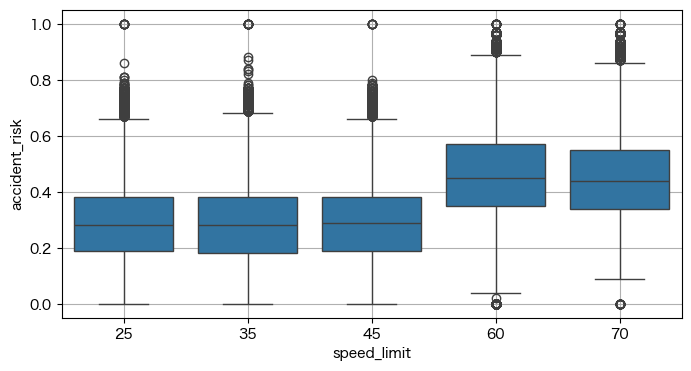

In [18]:
plt.figure(figsize=(8, 4))
sns.boxplot(x="speed_limit", y=target_col, data=train)
plt.grid()
plt.show()

num_reported_accidents

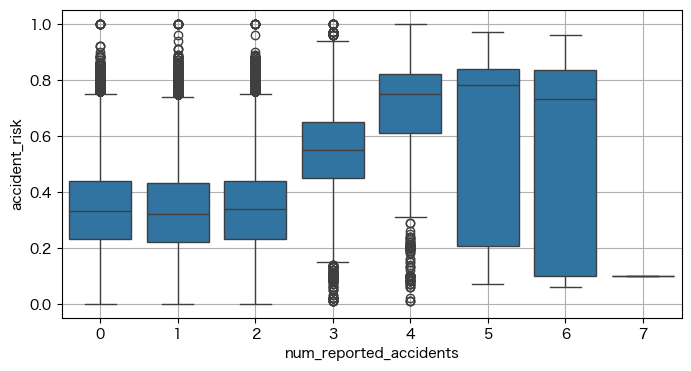

In [19]:
plt.figure(figsize=(8, 4))
sns.boxplot(x="num_reported_accidents", y=target_col, data=train)
plt.grid()
plt.show()

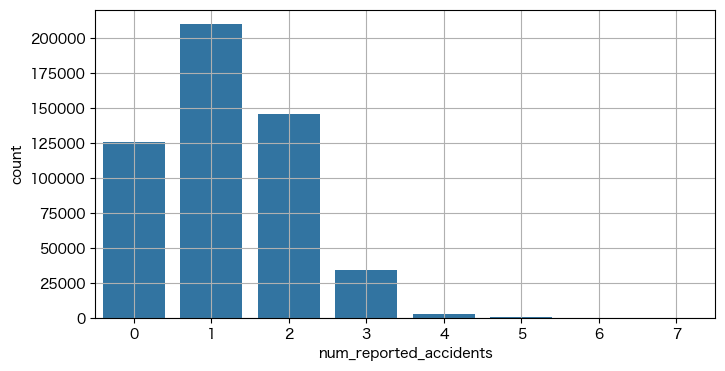

In [20]:
plt.figure(figsize=(8, 4))
sns.countplot(x="num_reported_accidents", data=train)
plt.grid()
plt.show()

num_lanes

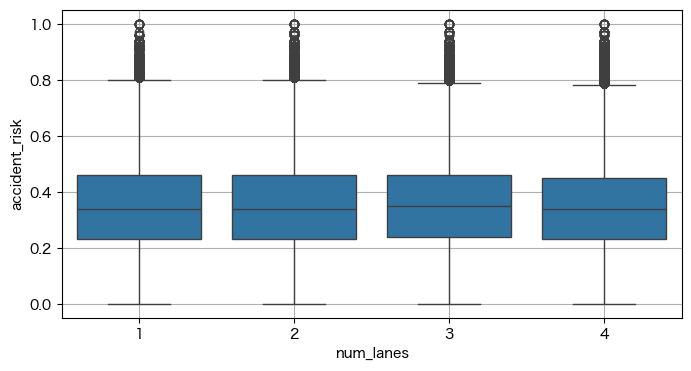

In [21]:
plt.figure(figsize=(8, 4))
sns.boxplot(x="num_lanes", y=target_col, data=train)
plt.grid()
plt.show()

## カテゴリ型変数と目的変数の関係

In [22]:
cat_features

['road_type',
 'lighting',
 'weather',
 'road_signs_present',
 'public_road',
 'time_of_day',
 'holiday',
 'school_season']

In [23]:
def plot_categorycal_boxplots(data, cat_cols, target_col):
    for col in cat_cols:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=col, y=target_col, data=data)
        plt.title(f"{col} vs {target_col}")
        plt.grid()
        plt.show()

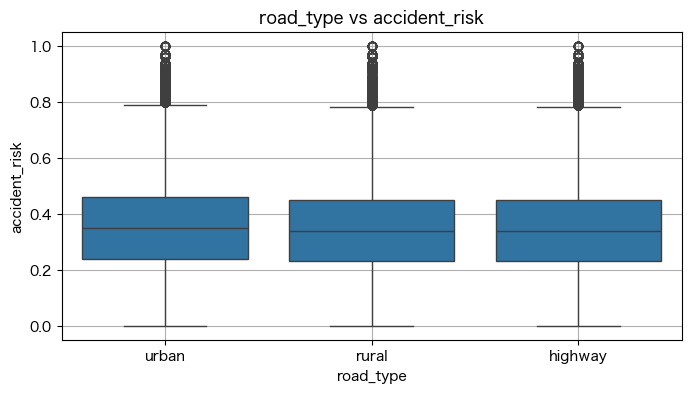

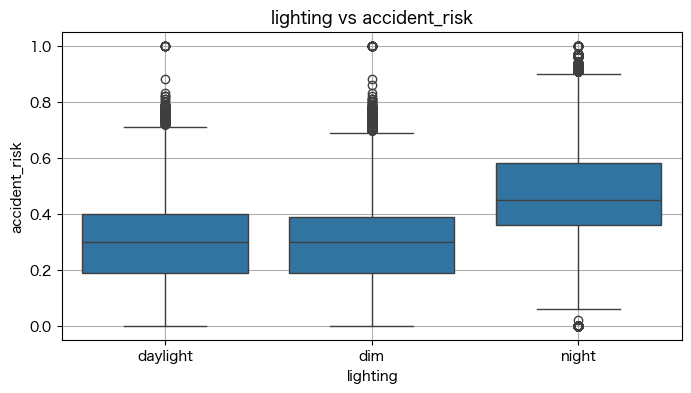

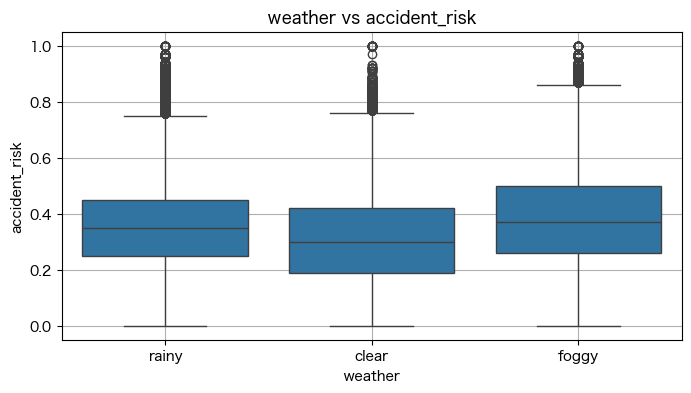

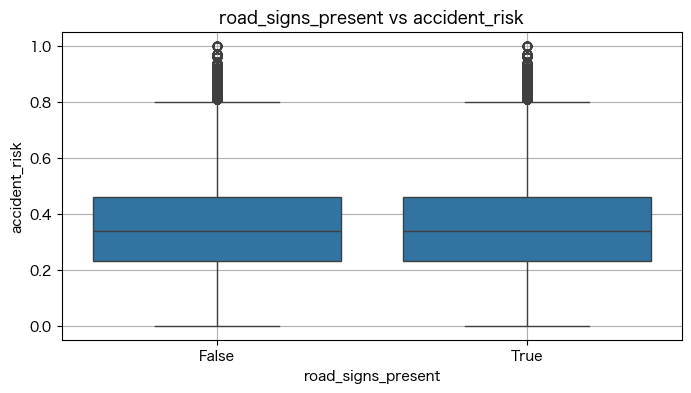

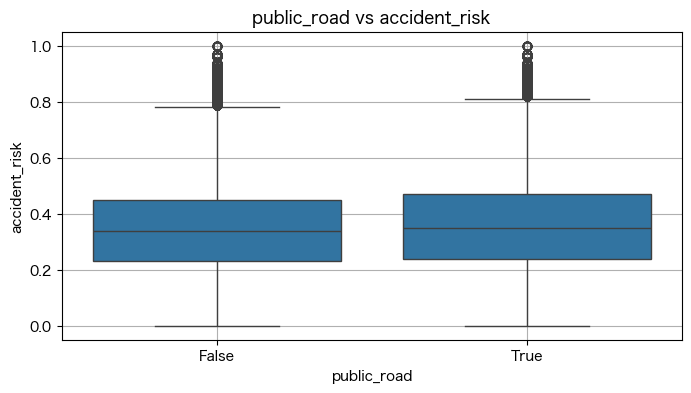

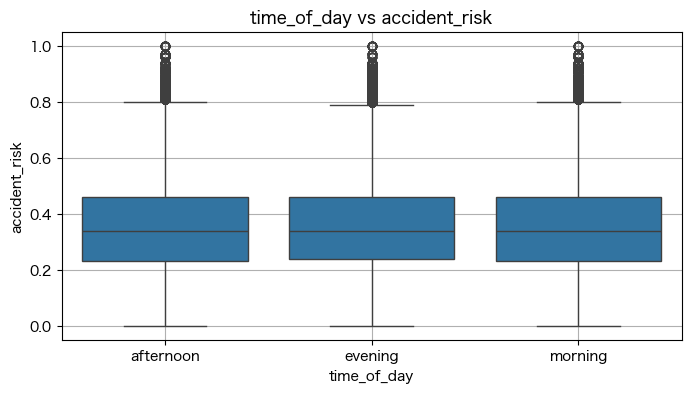

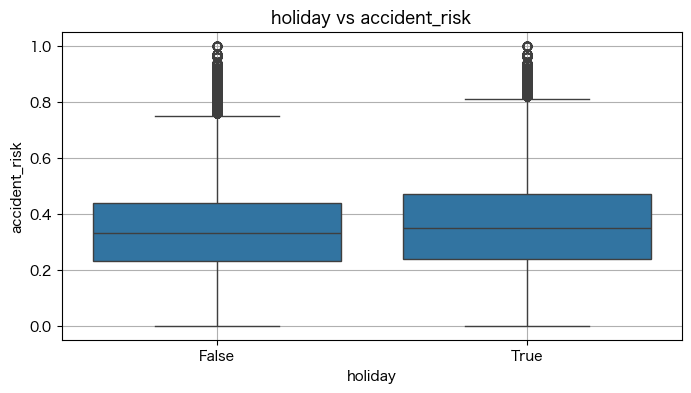

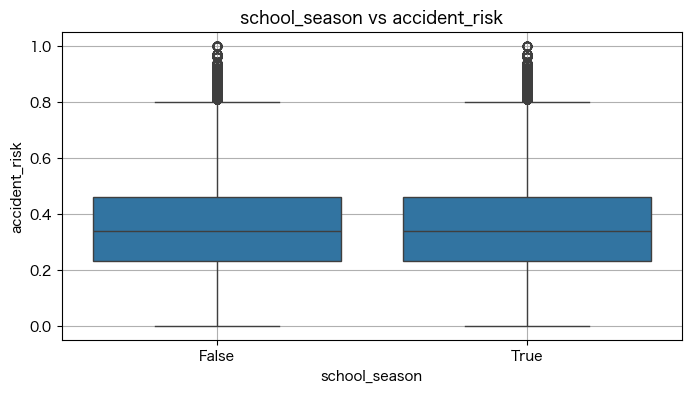

In [24]:
plot_categorycal_boxplots(train, cat_features, target_col)

In [25]:
def cross_tab_print(df: pd.DataFrame, row_col: str, col_col: str, normalize: bool = True):
    """
    df        : pandas.DataFrame
    row_col   : 行方向に使うカラム名
    col_col   : 列方向に使うカラム名
    normalize : True のとき行方向で割合も表示する
    """
    # 件数ベース
    ct_count = pd.crosstab(df[row_col], df[col_col])
    print("=== count ===")
    print(ct_count)

    if normalize:
        ct_ratio = pd.crosstab(
            df[row_col],
            df[col_col],
            normalize="index"
        )
        print("\n=== ratio (row-normalized) ===")
        print(ct_ratio.round(3))

In [26]:
# 件数＋割合を表示
cross_tab_print(train, "lighting", "time_of_day")
cross_tab_print(train, "lighting", "weather")
cross_tab_print(train, "weather", "time_of_day")

# 件数だけ表示したいとき
# cross_tab_print(df, "lighting", "weather", normalize=False)

=== count ===
time_of_day  afternoon  evening  morning
lighting                                
daylight         59267    59416    59332
dim              61425    60967    61434
night            50815    52454    52644

=== ratio (row-normalized) ===
time_of_day  afternoon  evening  morning
lighting                                
daylight         0.333    0.334    0.333
dim              0.334    0.332    0.334
night            0.326    0.336    0.338
=== count ===
weather   clear  foggy  rainy
lighting                     
daylight  58549  63563  55903
dim       58867  66011  58948
night     61890  51889  42134

=== ratio (row-normalized) ===
weather   clear  foggy  rainy
lighting                     
daylight  0.329  0.357  0.314
dim       0.320  0.359  0.321
night     0.397  0.333  0.270
=== count ===
time_of_day  afternoon  evening  morning
weather                                 
clear            60018    58811    60477
foggy            59846    62822    58795
rainy            516